In [2]:
from __future__ import division
import math
import numpy as np
import torch
from torchvision.models.alexnet import alexnet
from torchvision.models.vgg import vgg16, vgg19
from torchvision.models.resnet import resnet18, resnet50
from torchvision.models.densenet import densenet121
from torchvision.models.inception import Inception3 as inception3
import sys
import random

sys.path.append('../../../code/python')

from models.mobilenet import mobilenet
from models.squeezenet import squeezenet1_0

from torch.autograd import Variable

import matplotlib.pyplot as plt
from plot_commons import get_ivm_patch_coordinates, calculate_ivm_flops, calculate_flops

random.seed(45)
np.random.seed(45)

torch.set_num_threads(8)

### Redundency ratios calculation

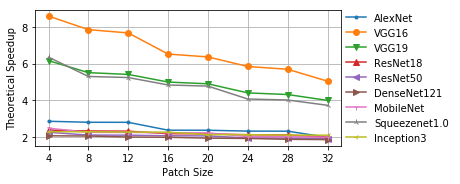

In [12]:
fig = plt.figure(figsize=(5.5, 2.5))

x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 224, 224), dtype=np.float32)))
models = [alexnet(), vgg16(), vgg19(), resnet18(), resnet50(), densenet121(), mobilenet(), squeezenet1_0()]


patch_sizes = [4, 8, 12, 16, 20, 24, 28, 32]

markers = [".","o","v","^","<",">","1","2"]
for name, model, m in zip(['AlexNet', 'VGG16', 'VGG19', 'ResNet18', 'ResNet50', 'DenseNet121', 'MobileNet',
                       'Squeezenet1.0'], models, markers):

    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
  
    r = []
    for patch_size in patch_sizes:
        
        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)
        
    plt.plot(patch_sizes, r, label=name, marker=m)
    
    
x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 299, 299), dtype=np.float32)))
models = [inception3()]
markers = ["3"]
for name, model, m in zip(['Inception3'], models, markers):

    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()

    r = []
    for patch_size in patch_sizes:
        
        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (299-patch_size)//2
        j = (299-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph) / (1000 ** 2)
        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)
        
    plt.plot(patch_sizes, r, label=name, marker=m)

lgd = plt.legend(loc='center right', bbox_to_anchor=(1.38, 0.5), ncol=1, frameon=False)
plt.grid()
plt.ylabel('Theoretical Speedup')
plt.xlabel('Patch Size')
plt.xticks(patch_sizes, patch_sizes)

plt.savefig('../images/redundancy_ratio.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Thresholding Redundency ratios

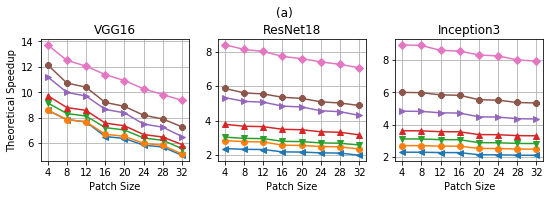

In [4]:
x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 224, 224), dtype=np.float32)))
patch_sizes = [4, 8, 12, 16, 20, 24, 28, 32]
taus = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

markers = ['<', 'o', 'v', '^', '>', '8', 'D']


plt.figure(figsize=(9,2.5))

ax = plt.subplot(1, 3, 1)
model = vgg16()
for tau,m in zip(taus, markers):
    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
    
    r = []
    for patch_size in patch_sizes:

        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph, tau=tau) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)

    plt.plot(patch_sizes, r, label=r'$\tau = $' + str(tau), marker=m)

ax.set_title('VGG16')
plt.grid()
plt.ylabel('Theoretical Speedup')
plt.xlabel('Patch Size')
plt.xticks(patch_sizes, patch_sizes)


ax = plt.subplot(1, 3, 2)
model = resnet18()
for tau,m in zip(taus, markers):
    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
    
    r = []
    for patch_size in patch_sizes:

        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph, tau=tau) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)

    plt.plot(patch_sizes, r, label=r'$\tau = $' + str(tau), marker=m)

ax.set_title('ResNet18')    
plt.grid()
plt.xlabel('Patch Size')
plt.xticks(patch_sizes, patch_sizes)

    
x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 299, 299), dtype=np.float32)))    
ax = plt.subplot(1, 3, 3)
model = inception3()
for tau,m in zip(taus, markers):
    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
    
    r = []
    for patch_size in patch_sizes:

        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph, tau=tau) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)

    plt.plot(patch_sizes, r, label=r'$\tau = $' + str(tau), marker=m)
    
ax.set_title('Inception3')
plt.grid()
plt.xlabel('Patch Size')
plt.xticks(patch_sizes, patch_sizes)    
        
# lgd = plt.legend(loc='lower center', bbox_to_anchor=(-0.7, -0.47), ncol=8)
stit = plt.suptitle('(a)')
plt.subplots_adjust(top=0.8)
plt.savefig('../images/th_redundancy_ratio.pdf', bbox_extra_artists=(stit,), bbox_inches='tight')
plt.show()

In [5]:
from models.flops_benchmark import add_flops_counting_methods

model = inception3()
model = model.eval()
model = add_flops_counting_methods(model)
model.start_flops_count()

x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 299, 299), dtype=np.float32)))
model(x)
print(model.compute_average_flops_cost() / 1e9 / 2)

5.711168096
